# **Part A: Data Preprocessing & Baseline**

### 1.  Data Loading and Feature Engineering:

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [11]:
df = pd.read_csv("hour.csv")

In [12]:
df.isnull().sum().sum()

np.int64(0)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [14]:
df = df.drop(columns=["instant", "dteday", "casual", "registered"])

In [15]:
categorical_cols = ["season", "weathersit", "mnth", "hr", "weekday", "workingday", "holiday"]
numerical_cols = [col for col in df.columns if col not in categorical_cols + ["cnt"]]

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
    ],
    remainder="passthrough"
)

In [17]:
X = df.drop(columns=["cnt"])
y = df["cnt"]

In [18]:
X_processed = preprocessor.fit_transform(X)

### 2.  Train/Test Split:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

### 3.  Baseline Model (Single Regressor):

In [20]:
dt = DecisionTreeRegressor(max_depth=6, random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_pred))

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

In [22]:
print("Decision Tree RMSE:", dt_rmse)
print("Linear Regression RMSE:", lr_rmse)

Decision Tree RMSE: 118.45551730357617
Linear Regression RMSE: 100.44594634649623


# **Part B: Ensemble Techniques**

### 1.  Bagging (Variance Reduction):

In [23]:
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

In [24]:
bagging = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=6, random_state=42),
    n_estimators=50,
    random_state=42
)
bagging.fit(X_train, y_train)
bagging_pred = bagging.predict(X_test)
bagging_rmse = np.sqrt(mean_squared_error(y_test, bagging_pred))

print("Bagging RMSE:", bagging_rmse)

Bagging RMSE: 112.34963461581316


In [26]:
bagging2 = BaggingRegressor(
    estimator=LinearRegression(),
    n_estimators=50,
    random_state=42
)
bagging2.fit(X_train, y_train)
bagging2_pred = bagging2.predict(X_test)
bagging2_rmse = np.sqrt(mean_squared_error(y_test, bagging2_pred))

print("Bagging RMSE:", bagging2_rmse)

Bagging RMSE: 100.4199508123649


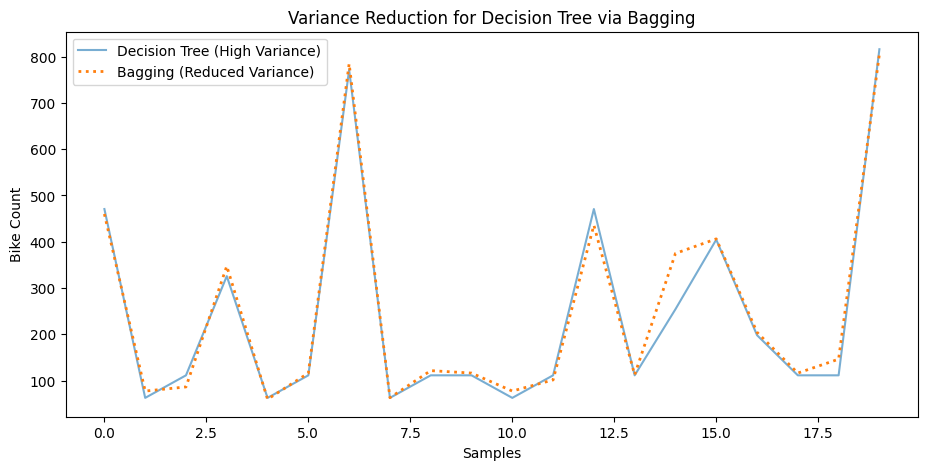

In [68]:
plt.figure(figsize=(11,5))

n = 20
plt.plot(dt_pred[:n], label="Decision Tree (High Variance)", alpha=0.6)
plt.plot(bagging_pred[:n], label="Bagging (Reduced Variance)", linewidth=2, linestyle="dotted")

plt.title("Variance Reduction for Decision Tree via Bagging")
plt.xlabel("Samples")
plt.ylabel("Bike Count")
plt.legend()
plt.show()

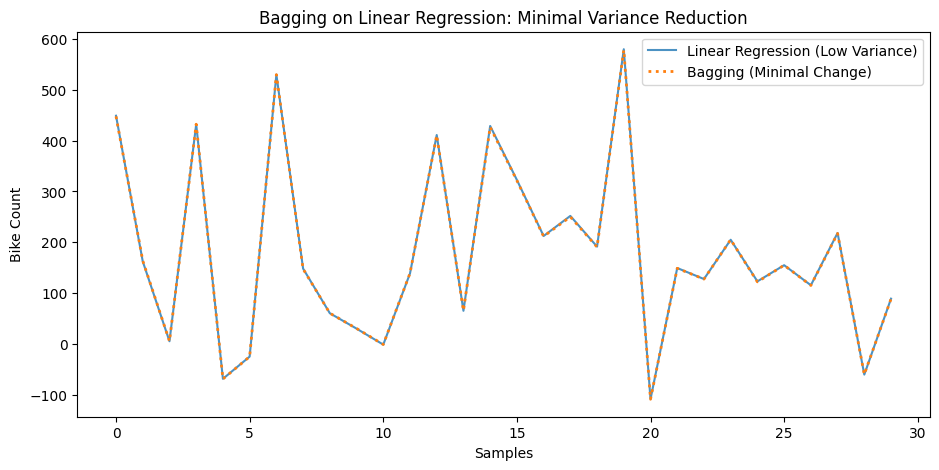

In [67]:
plt.figure(figsize=(11,5))

plt.plot(lr_pred[:30], label="Linear Regression (Low Variance)", alpha=0.8)
plt.plot(bagging2_pred[:30], label="Bagging (Minimal Change)", linewidth=2, linestyle="dotted")

plt.title("Bagging on Linear Regression: Minimal Variance Reduction")
plt.xlabel("Samples")
plt.ylabel("Bike Count")
plt.legend()
plt.show()


### 2.  Boosting (Bias Reduction): 

In [28]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_pred))

print("Gradient Boosting RMSE:", gbr_rmse)

Gradient Boosting RMSE: 78.96518555055427


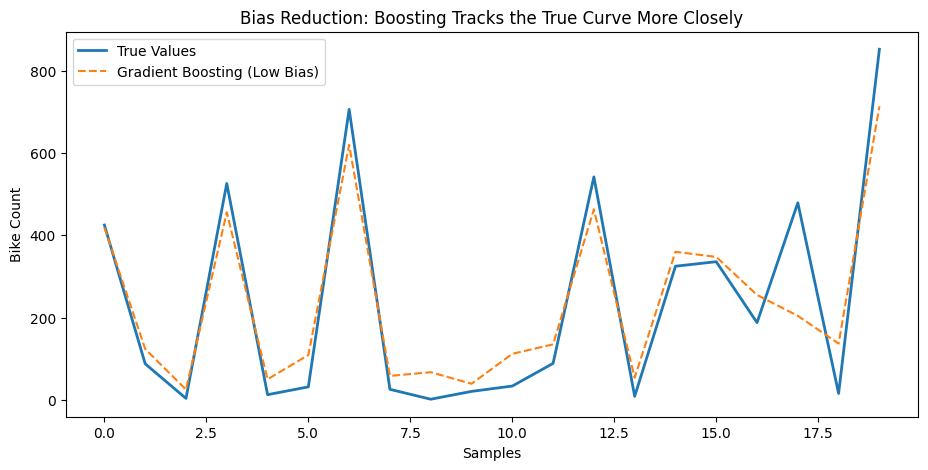

In [50]:
plt.figure(figsize=(11,5))

plt.plot(y_test.values[:20], label="True Values", linewidth=2)
plt.plot(gbr_pred[:20], label="Gradient Boosting (Low Bias)", linestyle="--")

plt.title("Bias Reduction: Boosting Tracks the True Curve More Closely")
plt.xlabel("Samples")
plt.ylabel("Bike Count")
plt.legend()
plt.show()

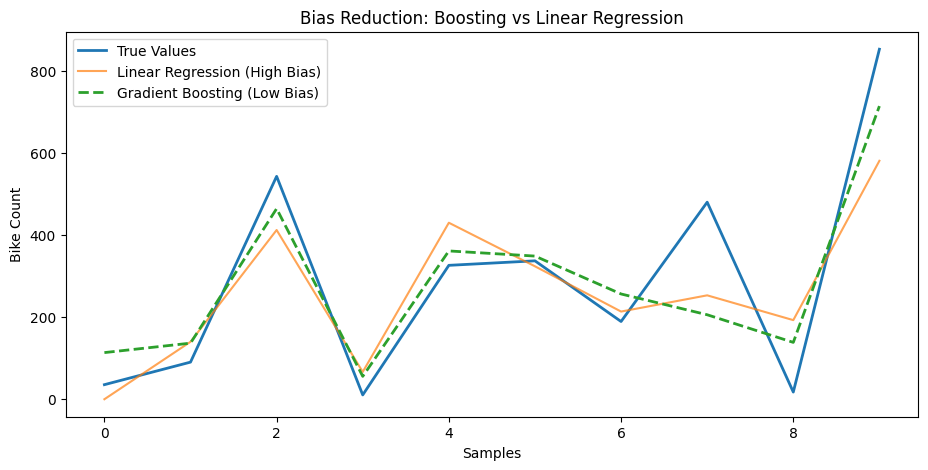

In [74]:
plt.figure(figsize=(11,5))
m = 10
n = 20
plt.plot(y_test.values[m:n], label="True Values", linewidth=2)
plt.plot(lr_pred[m:n], label="Linear Regression (High Bias)", alpha=0.7)
plt.plot(gbr_pred[m:n], label="Gradient Boosting (Low Bias)", linestyle="--", linewidth=2)

plt.title("Bias Reduction: Boosting vs Linear Regression")
plt.xlabel("Samples")
plt.ylabel("Bike Count")
plt.legend()
plt.show()


# **Part C: Stacking Regressor**

### **Explanation: Principle of Stacking & Meta-Learner Behavior**

- Stacking is an ensemble technique that combines the strengths of multiple diverse base models to produce a final prediction that is typically more accurate than any single model.



### **How Stacking Works**

<p align="center">
  <img src="image.png" width="400">
</p>

#### Level-0 learners (Base Models)
These models independently learn patterns from the same training data.

**In our case:**

1. KNN Regressor (instance-based, non-parametric)
2. Bagging Regressor (variance-reduction ensemble)
3. Gradient Boosting Regressor (bias-reduction ensemble)

> Each brings different inductive biases and captures different aspects of the data.

#### Meta-Learner (Level-1 model)
After the base learners make their predictions, those predictions become input features for a second model—the meta-learner.

> In our case: Ridge Regression is the meta-learner.

---

### **How the Meta-Learner Learns Optimal Combination**

The meta-learner receives:

- Predictions from KNN
- Predictions from Bagging
- Predictions from Gradient Boosting

The outputs are treated just like normal numeric features. The meta-learner is trained to minimize the final prediction error (RMSE) by:

+ Learning which base model is more reliable for specific patterns in the data.

+ Adjusting weights accordingly (Ridge helps prevent overfitting by penalizing overly large weights).

+ Combining base-model outputs in a way that reduces bias and variance simultaneously.

In [29]:
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge

In [30]:
level0 = [
    ("knn", KNeighborsRegressor()),
    ("bagging", bagging),
    ("gbr", gbr)
]

In [31]:
meta = Ridge()

In [32]:
stack = StackingRegressor(
    estimators=level0,
    final_estimator=meta,
    passthrough=False
)

In [33]:
stack.fit(X_train, y_train)
stack_pred = stack.predict(X_test)
stack_rmse = np.sqrt(mean_squared_error(y_test, stack_pred))

print("Stacking Regressor RMSE:", stack_rmse)

Stacking Regressor RMSE: 67.05385916199337


In [70]:
results = {
    "Model": [
        "Decision Tree (Baseline)",
        "Linear Regression (Baseline)",
        "Bagging Regressor (Decision Tree)",
        "Bagging Regressor (Linear Regressor)",
        "Gradient Boosting Regressor",
        "Stacking Regressor"
    ],
    "RMSE": [
        dt_rmse,
        lr_rmse,
        bagging_rmse,
        bagging2_rmse,
        gbr_rmse,
        stack_rmse
    ]
}

results_df = pd.DataFrame(results)


# **Part D: Conclusion**

In [71]:
results_df

,Model,RMSE
0,Decision Tree (Baseline),118.455517
1,Linear Regression (Baseline),100.445946
2,Bagging Regressor (Decision Tree),112.349635
3,Bagging Regressor (Linear Regressor),100.419951
4,Gradient Boosting Regressor,78.965186
5,Stacking Regressor,67.053859


### **Best Performing Model - Stacking Regressor**

Based on the RMSE comparison across all models, the **Stacking Regressor** achieved the best performance (RMSE ≈ **67.05**), outperforming every single model and ensemble method used in the analysis.

### Why Stacking Outperformed

* The **Stacking Regressor** achieved the lowest RMSE (**67.05**).
* By combining models with different strengths (KNN → local patterns, Bagging → variance reduction, Boosting → bias reduction), stacking leverages **model diversity**.
* The meta-learner (Ridge Regression) learns the optimal weighted combination of these predictions, leading to superior generalization.


The results clearly reflect the theoretical expectations about **bias–variance trade-offs**:

The experiment demonstrates that **no single model is universally superior**.
However, **ensemble diversity**—combining models that make different types of errors—allows stacking to achieve the best bias–variance balance and ultimately deliver the strongest predictive performance.
